In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [72]:
train_df = pd.read_csv('D:/IIT-G INTERNSP/HACKATHON 2/Train_Data.csv')
test_df = pd.read_csv('D:/IIT-G INTERNSP/HACKATHON 2/Test_Data.csv')

# Save test IDs for submission
test_ids = test_df['SEQN']

In [73]:
# Drop SEQN
train_df.drop(columns=['SEQN'], inplace=True)
test_df.drop(columns=['SEQN'], inplace=True)

# Map target variable
train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})
train_df = train_df.dropna(subset=['age_group'])

In [74]:
train_df['age_group'].isnull().sum()

np.int64(0)

In [75]:
train_df.head(20)

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,0.0
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85,0.0
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14,0.0
3,1.0,2.0,28.9,104.0,NaN,84.0,16.15,0.0
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92,0.0
5,1.0,2.0,23.6,110.0,2.0,100.0,6.08,0.0
6,1.0,2.0,38.7,94.0,2.0,202.0,21.11,0.0
7,2.0,2.0,38.3,107.0,2.0,164.0,20.93,0.0
8,1.0,2.0,38.9,89.0,2.0,113.0,17.47,1.0
9,1.0,1.0,28.9,90.0,2.0,95.0,3.24,0.0


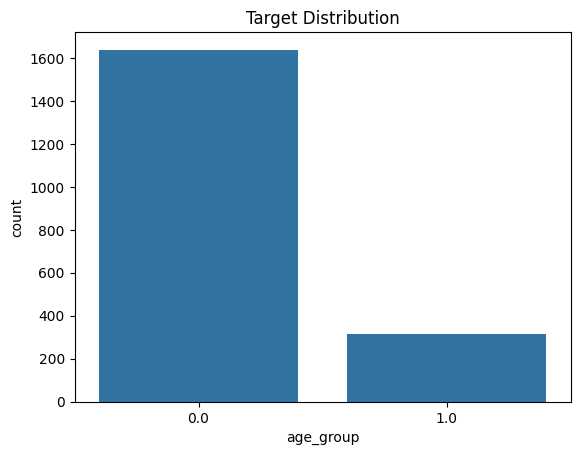

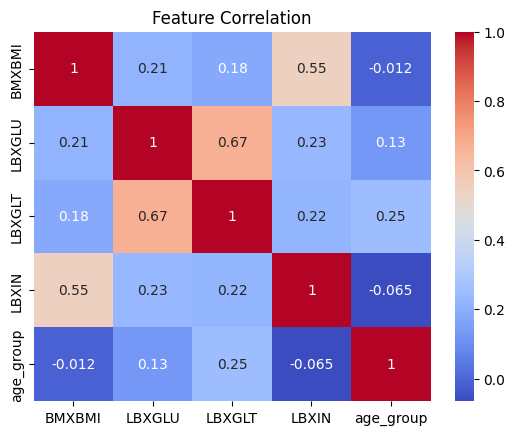

In [76]:
# Plot target distribution
sns.countplot(data=train_df, x='age_group')
plt.title('Target Distribution')
plt.show()

# Correlation heatmap
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
corr = train_df[num_cols + ['age_group']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [77]:
cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']

# Replace 7/9 in categorical with NaN
for col in cat_cols:
    train_df[col] = train_df[col].replace([7, 9], np.nan)
    test_df[col] = test_df[col].replace([7, 9], np.nan)

# Imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])

test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

In [61]:
train_df.head()

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,0.0
1,2.0,2.0,20.3,89.0,2.0,80.0,3.85,0.0
2,1.0,2.0,23.2,89.0,2.0,68.0,6.14,0.0
3,1.0,2.0,28.9,104.0,2.0,84.0,16.15,0.0
4,2.0,1.0,35.9,103.0,2.0,81.0,10.92,0.0


In [78]:
# Create new features
X = train_df.drop(columns='age_group')
y = train_df['age_group']
X_test = test_df.copy()

X['is_female'] = (X['RIAGENDR'] == 2).astype(int)
X_test['is_female'] = (X_test['RIAGENDR'] == 2).astype(int)

X['physically_active'] = (X['PAQ605'] == 1).astype(int)
X_test['physically_active'] = (X_test['PAQ605'] == 1).astype(int)

X['diabetic'] = (X['DIQ010'] == 1).astype(int)
X_test['diabetic'] = (X_test['DIQ010'] == 1).astype(int)

X.drop(columns=cat_cols, inplace=True)
X_test.drop(columns=cat_cols, inplace=True)

X['glucose_bmi'] = X['LBXGLU'] * X['BMXBMI']
X_test['glucose_bmi'] = X_test['LBXGLU'] * X_test['BMXBMI']

In [79]:
y.isnull().sum()

np.int64(0)

In [80]:
scaler = StandardScaler()
X[num_cols + ['glucose_bmi']] = scaler.fit_transform(X[num_cols + ['glucose_bmi']])
X_test[num_cols + ['glucose_bmi']] = scaler.transform(X_test[num_cols + ['glucose_bmi']])

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced',random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    print(f'{name} F1 Score: {score:.4f}')

Random Forest F1 Score: 0.1690
XGBoost F1 Score: 0.3125


In [123]:
import warnings
warnings.filterwarnings('ignore')  # To ignore XGBoost warnings

# 1. Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Set parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features' : ['sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

# 3. Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# 4. Grid Search Loop
for name, model in models.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grids[name],
                        scoring=make_scorer(f1_score),
                        cv=5,
                        n_jobs=-1,
                        verbose=1)
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    preds = best_model.predict(X_val)
    score = f1_score(y_val, preds)
    
    print(f'{name} Best F1 Score: {score:.4f}')
    print(f'Best Params: {grid.best_params_}')



Tuning Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Random Forest Best F1 Score: 0.3559
Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

Tuning XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
XGBoost Best F1 Score: 0.2697
Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}


In [126]:
# Retrain on full data
final_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
final_model.fit(X, y)

# Predict
final_preds = final_model.predict(X_test)

# Save submission
submission = pd.DataFrame({
        'age_group': final_preds
})


In [128]:
submission.to_csv('final_submission.csv', index=False)
print("✅ Final submission saved as 'final_submission.csv'")

✅ Final submission saved as 'final_submission.csv'
